# **Modelos Benchmarks**

In [180]:
# Librerias Importadas

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera

In [122]:
# Cargar datos
df = pd.read_csv(r"C:\Users\TAWTOCA\OneDrive - Universidad del Norte\Documentos\Visual Files\16-21.csv")



df.head()

,FECHA_CORTE,TIPO_ENTIDAD,NOMBRE_TIPO_ENTIDAD,CODIGO_ENTIDAD,NOMBRE_ENTIDAD,TIPO_NEGOCIO,NOMBRE_TIPO_PATRIMONIO,SUBTIPO_NEGOCIO,NOMBRE_SUBTIPO_PATRIMONIO,CODIGO_NEGOCIO,...,VALOR_UNIDAD_OPERACIONES_DIA_T,APORTES_RECIBIDOS,RETIROS_REDENCIONES,ANULACIONES,VALOR_FONDO_CIERRE_DIA_T,NUMERO_INVERSIONISTAS,RENTABILIDAD_DIARIA,RENTABILIDAD_MENSUAL,RENTABILIDAD_SEMESTRAL,RENTABILIDAD_ANUAL
0,2016-01-01,5,SF-SOCIEDAD FIDUCIARIA,20,Fiduciaria Corficolombiana S.A.,9,FONDOS DE INVERSIÓN COLECTIVA,1,FIC DE TIPO GENERAL,53954,...,31051.177754,0.0,0.0,0.0,9.303540e+11,5213.0,4.925178,4.540000,3.020000,3.190000
1,2016-01-01,5,SF-SOCIEDAD FIDUCIARIA,40,Fiducoldex,9,FONDOS DE INVERSIÓN COLECTIVA,7,FONDOS DE CAPITAL PRIVADO,11207,...,22230.562658,0.0,0.0,0.0,1.370691e+11,4.0,0.000071,7.398338,47.588044,25.129215
2,2016-01-01,85,COMISIONISTAS DE BOLSA DE VALORES,28,Credicorp Capital,9,FONDOS DE INVERSIÓN COLECTIVA,1,FIC DE TIPO GENERAL,58919,...,11330.202179,0.0,0.0,0.0,1.142338e+10,32.0,1.049611,-4.692300,0.631400,3.371184
3,2016-01-01,85,COMISIONISTAS DE BOLSA DE VALORES,21,Profesionales De Bolsa,9,FONDOS DE INVERSIÓN COLECTIVA,7,FONDOS DE CAPITAL PRIVADO,59859,...,10053.318931,0.0,0.0,0.0,7.128130e+09,13.0,-3.038200,5.764400,0.000000,0.000000
4,2016-01-01,85,COMISIONISTAS DE BOLSA DE VALORES,14,Btg Pactual,9,FONDOS DE INVERSIÓN COLECTIVA,1,FIC DE TIPO GENERAL,58699,...,9326.594797,0.0,0.0,0.0,5.055087e+08,17.0,-2.887314,145.398140,0.000000,0.000000


In [123]:
(df == 0).sum()


FECHA_CORTE                                               0
TIPO_ENTIDAD                                              0
NOMBRE_TIPO_ENTIDAD                                       0
CODIGO_ENTIDAD                                            0
NOMBRE_ENTIDAD                                            0
TIPO_NEGOCIO                                              0
NOMBRE_TIPO_PATRIMONIO                                    0
SUBTIPO_NEGOCIO                                           0
NOMBRE_SUBTIPO_PATRIMONIO                                 0
CODIGO_NEGOCIO                                            0
NOMBRE_PATRIMONIO                                         0
PRINCIPAL_COMPARTIMENTO                                   0
TIPO_PARTICIPACION                                        0
RENDIMIENTOS_ABONADOS                                 69998
PRECIERRE_FONDO_DIA_T                                 19143
NUMERO_UNIDADES_FONDO_CIERRE_OPER_DIA_T_ANTERIOR      19001
VALOR_UNIDAD_OPERACIONES_DIA_T          

In [175]:
# Definir variables predictoras y respuesta
X = df[["APORTES_RECIBIDOS", "RENDIMIENTOS_ABONADOS", "PRECIERRE_FONDO_DIA_T", "ANULACIONES", "TIPO_ENTIDAD"]]
y = df["RETIROS_REDENCIONES"]

# Crear un filtro para eliminar valores negativos en y y X
mask = (y >= 0) & (X >= 0).all(axis=1)

# Aplicar el filtro
X_clean = X[mask]
y_clean = y[mask]


# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [176]:
# Escalar los datos
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

In [84]:
models_dict = {
    "ridge": Ridge(alpha=1.0),
    "lasso": Lasso(alpha=1.0),
    "linear": LinearRegression(),
    "randomforest": RandomForestRegressor(),
    "knn": KNeighborsRegressor(),
    "svr": SVR(),
    "xgboost": XGBRegressor()
}

## **Regresión Lineal**

In [177]:
lr = LinearRegression().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

Training set score: 0.73
Test set score: 0.70


La diferencia entre entrenamiento y prueba es pequeña, lo que sugiere que el modelo no está sobreajustando.

In [178]:
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [191]:
# Calcular métricas
mae = mean_absolute_error(y_test, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2 = r2_score(y_test, y_test_pred)

# Residuos
residuos = y_test - y_test_pred

# Pruebas estadísticas
ljung_box_p_value = acorr_ljungbox(residuos, lags=[10]).iloc[0, 1]

jarque_bera_p_value = jarque_bera(residuos)[1]

# Mostrar resultados
resultados = pd.DataFrame({
    "MAE": [mae],
    "RMSE": [rmse],
    "R²": [r2],
    "Ljung-Box p-value": [ljung_box_p_value],
    "Jarque-Bera p-value": [jarque_bera_p_value]
})

print(resultados)


            MAE          RMSE        R²  Ljung-Box p-value  \
0  1.927087e+09  1.085675e+10  0.695731           0.325568   

   Jarque-Bera p-value  
0                  0.0  


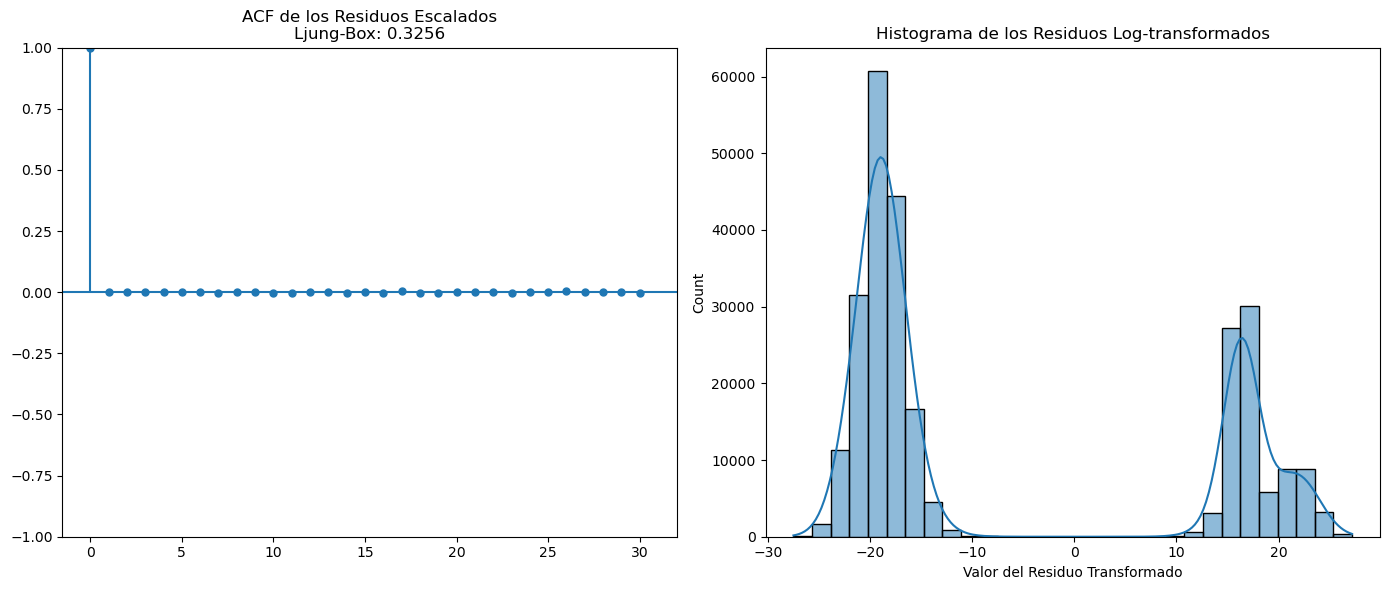

In [189]:
# Aplicar transformaciones
residuos_esc = (residuos - np.mean(residuos)) / np.std(residuos)  # Escalar residuos
residuos_log = np.log1p(np.abs(residuos)) * np.sign(residuos)  # Log-transformación
 # Transformar p-valor

# Gráficos
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 📊 Gráfico 1: ACF de los residuos escalados
plot_acf(residuos_esc, ax=axes[0], lags=30)
axes[0].set_title(f"ACF de los Residuos Escalados\nLjung-Box: {ljung_box_p_value:.4f}")

# 📊 Gráfico 2: Histograma de los residuos log-transformados
sns.histplot(residuos_log, bins=30, kde=True, ax=axes[1])
axes[1].set_title("Histograma de los Residuos Log-transformados")
axes[1].set_xlabel("Valor del Residuo Transformado")

# Mostrar gráficos
plt.tight_layout()
plt.show()

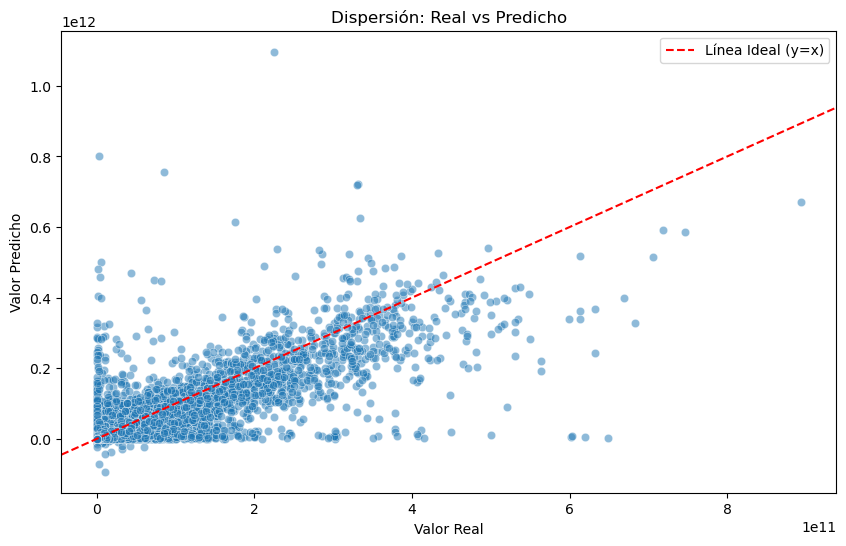

In [195]:

# Crear el scatter plot (gráfico de dispersión)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.5)

# Agregar línea de referencia y etiquetas
plt.axline((0, 0), slope=1, color="red", linestyle="--", label="Línea Ideal (y=x)")
plt.xlabel("Valor Real")
plt.ylabel("Valor Predicho")
plt.title("Dispersión: Real vs Predicho")
plt.legend()

# Mostrar gráfico
plt.show()

## **Regresión de Ridge**